### A nonlinear inversion of deformation data using Mogi's model

This notebook follows from the ols_mogi_example

In this notebook we do an inversion of the Mogi Sakurajima data using the curve_fit routine in scipy.optimize.

curve_fit uses an inversion algorithm that is scipy.optimize.least_squares with the Trust Region Reflective algorithm ('TRF')

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats as stats
from sklearn.metrics import *
from statsmodels.stats.stattools import durbin_watson

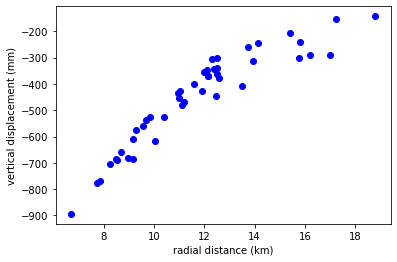

In [2]:
sakura = [(17.0,-291),(16.2,-291),(15.75,-302),(13.5,-407),(12.45,-446),(10.4,-527),(8.7,-658),(7.85,-770),
          (6.7,-894),(7.75,-776),(8.25,-703),(9.15,-608),(9.85,-526),(9.7,-536),(9.55,-560),(9.3,-577),(8.5,-684),
          (8.55,-690),(8.95,-681),(9.15,-685),(10.05,-616),(11.1,-481),(11.9,-427),(12.15,-369),(12.1,-348),
          (12.5,-301),(12.3,-306),(10.95,-433),(11.05,-426),(11.0,-453),(12.0,-356),(12.4,-344),(12.5,-363),
          (11.6,-401),(11.2,-468),(12.6,-379),(13.95,-314),(15.8,-242),(12.15,-369),(12.5,-338),(13.75,-260),
          (14.15,-244),(15.4,-206),(17.25,-155),(18.8,-143)]


# Compare the Mogi solution to observations
# for Salurajima following deflation after
# the 1914 eruption
radial, vert_displace = zip(*sakura)

plt.plot(radial, vert_displace, "bo")
plt.xlabel("radial distance (km)")
plt.ylabel("vertical displacement (mm)")
#plt.title("Mogi solution for 1914 Sakurajima deflation")

plt.show()

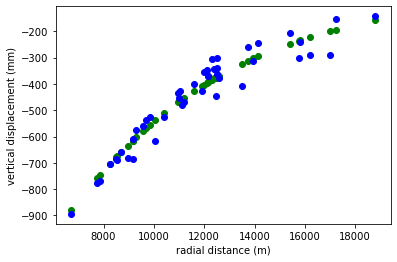

best-fit gamma =  -0.009816397328815772 +/- 0.00012927432437186338


In [3]:
#model 1 - find best fit gamma

def objective1(x, gamma):
    a = 2500
    d = 10000
    w = gamma * a**3*d/((x**2+d**2)**1.5) * 1000 
    return w  #displacement mm

xdata = np.array(radial)*1000
ydata = np.array(vert_displace)
popt1, pcov = curve_fit(objective1, xdata, ydata)
model1 = objective1(xdata, *popt1)

plt.plot(xdata, model1, 'go')
plt.plot(xdata, ydata, "bo")
plt.xlabel("radial distance (m)")
plt.ylabel("vertical displacement (mm)")
plt.show()

# uncertainty on the gamma parameter estimate
perr = np.sqrt(np.diag(pcov))
print("best-fit gamma = ", popt1[0], "+/-", perr[0])

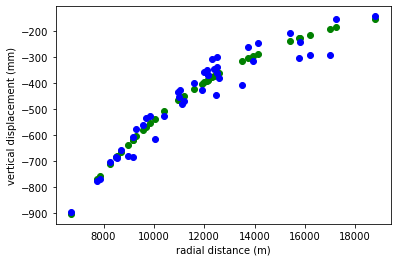

best-fit gamma: -0.009573040261390173 +/- 0.00023488133455696822
depth 9514.147977645063 +/- 415.27006384816127


In [4]:
#model 2
#invert on gamma and on depth, d, using scipy curvefit
# this is a nonlinear inversion problem
def objective2(x, gamma, d):
    a = 2500 #still specifying the radius
    w = gamma * a**3*d/((x**2+d**2)**1.5) * 1000 
    return w  #displacement mm

xdata = np.array(radial)*1000
ydata = np.array(vert_displace)

#note the bounds placed on the model parameters (try removing the bounds)
popt2, pcov = curve_fit(objective2, xdata, ydata, bounds=([-0.1,5000], [0,12000]))
model2 = objective2(xdata, *popt2)

plt.plot(xdata, model2, 'go')
plt.plot(xdata, ydata, "bo")
plt.xlabel("radial distance (m)")
plt.ylabel("vertical displacement (mm)")
plt.show()

# uncertainty on the gamma parameter estimate
# and depth estimate
# assuming the parameters are uncorrelated!
perr = np.sqrt(np.diag(pcov))
print("best-fit gamma:", popt2[0], "+/-", perr[0])
print("depth", popt2[1], "+/-", perr[1])

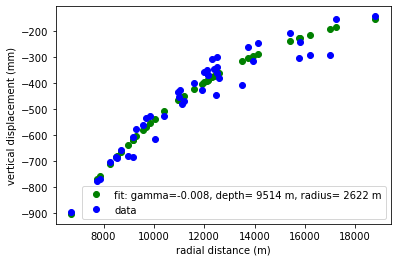

gamma: -0.008297314933643602 +/- 52333.024130366255
depth 9514.143627153428 +/- 421.9251686480084
radius 2622.0687726504425 +/- 5512658274.471984


In [6]:
# model 3
#invert on gamma and on depth, d, and radius, a using scipy curvefit
# this is a nonlinear inversion problem
def objective3(x, gamma, d, a):
    w = gamma * a**3*d/((x**2+d**2)**1.5) * 1000 
    return w  #displacement mm

xdata = np.array(radial)*1000
ydata = np.array(vert_displace)

#note the bounds placed on the model parameters (try removing the bounds)
popt3, pcov = curve_fit(objective3, xdata, ydata, bounds=([-0.01,3000, 1000], [-0.001,10000, 3000]))
model3 = objective3(xdata, *popt3)

plt.plot(xdata, model3, 'go', 
         label='fit: gamma=%5.3f, depth=%5.0f m, radius=%5.0f m' % tuple(popt3))
plt.plot(xdata, ydata, "bo", label='data')
plt.xlabel("radial distance (m)")
plt.ylabel("vertical displacement (mm)")
plt.legend()
plt.show()

# uncertainty on the gamma parameter estimate
# and depth and radius
# assuming the parameters are uncorrelated!
# a bad assumption in this case

perr = np.sqrt(np.diag(pcov))
print("gamma:", popt3[0], "+/-", perr[0])
print("depth", popt3[1], "+/-", perr[1])
print("radius", popt3[2], "+/-", perr[2])

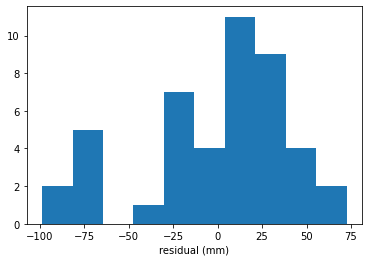

In [7]:
# just look at the residuals
residuals = ydata - model3
plt.hist(residuals)
plt.xlabel('residual (mm)')
plt.show()

In [8]:
class AssessModel():
    
    def __init__(self, num_obs, num_est_variables, obs, model):
        self.num_obs = num_obs
        self.num_est_variables = num_est_variables
        self.obs = obs
        self.max_obs = max(obs)
        self.min_obs = min(obs)
        self.model = model
        self.residuals = obs-model
        self.sse = (obs-model)**2
    
    def mse(self):
        mse = sum(self.sse)/self.num_obs
        return mse
    
    def rmse(self):
        rmse = np.sqrt(self.mse())
        return rmse
    
    def nrmse(self):
        nrmse = self.rmse() / (self.max_obs - self.min_obs)
        return nrmse
    
    def num_residuals(self):
        num_obs = self.num_obs
        return num_obs
        
    def log_likelihood(self):
        n = self.num_obs
        k = self.num_est_variables
        residuals = self.residuals

        ll = -(n * 1/2) * (1 + np.log(2 * np.pi)) - (n / 2) * np.log(residuals.dot(residuals) / n)

        return ll

    def AIC_BIC(self):
        ll = self.log_likelihood()
        n = self.num_obs
        k = self.num_est_variables + 1

        AIC = (-2 * ll) + (2 * k)
        BIC = (-2 * ll) + (k * np.log(n))

        return AIC, BIC

In [11]:
my_model = AssessModel(len(ydata), 1, ydata, model1)
print("MODEL 1")
print("gamma = ", popt1[0], ", depth = 10000m", ", radius = 2500 m")
print("number of data: ", my_model.num_residuals())
print("mean square error: ", my_model.mse())
print("root mean square error:", my_model.rmse())
print("normalized root mean square error:", my_model.nrmse())

print("log likelihood:", my_model.log_likelihood())
print ("AIC / BIC: ", my_model.AIC_BIC())

print()
my_model = AssessModel(len(ydata), 2, ydata, model2)
print("MODEL 2")
print("gamma = ", popt2[0], ", depth = ", popt2[1],  ", radius = 2500 m")
print("number of data: ", my_model.num_residuals())
print("mean square error: ", my_model.mse())
print("root mean square error:", my_model.rmse())
print("normalized root mean square error:", my_model.nrmse())

print("log likelihood:", my_model.log_likelihood())
print ("AIC / BIC: ", my_model.AIC_BIC())
print()

my_model = AssessModel(len(ydata), 3, ydata, model3)
print("MODEL 3")
print("gamma = ", popt3[0], ", depth = ", popt3[1],  ", radius =", popt3[2])
print("number of data: ", my_model.num_residuals())
print("mean square error: ", my_model.mse())
print("root mean square error:", my_model.rmse())
print("normalized root mean square error:", my_model.nrmse())

print("log likelihood:", my_model.log_likelihood())
print ("AIC / BIC: ", my_model.AIC_BIC())

MODEL 1
gamma =  -0.009816397328815772 , depth = 10000m , radius = 2500 m
number of data:  45
mean square error:  1785.928638791739
root mean square error: 42.260248920134615
normalized root mean square error: 0.05627196926782239
log likelihood: -232.32534460118657
AIC / BIC:  (468.65068920237314, 472.2640141819138)

MODEL 2
gamma =  -0.009573040261390173 , depth =  9514.147977645063 , radius = 2500 m
number of data:  45
mean square error:  1734.1062780305206
root mean square error: 41.642601720239824
normalized root mean square error: 0.055449536245325996
log likelihood: -231.66280153230025
AIC / BIC:  (469.3256030646005, 474.74559053391147)

MODEL 3
gamma =  -0.008297314933643602 , depth =  9514.143627153428 , radius = 2622.0687726504425
number of data:  45
mean square error:  1734.1062780265042
root mean square error: 41.6426017201916
normalized root mean square error: 0.055449536245261784
log likelihood: -231.66280153224812
AIC / BIC:  (471.32560306449625, 478.5522530235775)
